# The Hodrick-Prescott filter decomposes a time series into a smooth long-term trend and a short-term cyclical / irregular component. 

<p>In Hodrick-Prescott filtering, you use a Gaussian low-pass filter to smooth your time series. A Gaussian is a Fourier self-transform: $\mathcal{F} \{ {\rm Gaus} (t) \} = {\rm Gaus} (\xi)$, where $\xi$ is the frequency in cycles per time unit. The Fourier transform of a narrow Gaussian is a wide Gaussian, and vice versa.</p>

### Visualize the Gaussian Fourier transform:

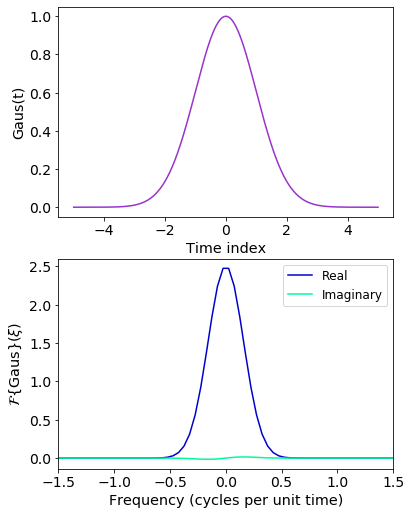

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import minimize_scalar
from scipy.fftpack import *
from itertools import cycle
from scipy.signal import freqz

# Use FT_approx again to get our Fourier transform and its frequencies
# all in one fell swoop
def FT_approx(x,t,Nfft):
    '''
    Approximate the Fourier transform of a finite duration
    signal using scipy.signal.freqz()

    Inputs
    ------
       x = input signal array
       t = time array used to create x(t)
    Nfft = the number of frdquency domain points used to
           approximate X(f) on the interval [fs/2,fs/2], where
           fs = 1/Dt. Dt being the time spacing in array t

    Return
    ------
    f = frequency axis array in Hz
    X = the Fourier transform approximation (complex)

    Mark Wickert, January 2015
    '''
    fs = 1/(t[1] - t[0])
    t0 = (t[-1]+t[0])/2 # time delay at center
    N0 = len(t)/2 # FFT center in samples
    f = np.arange(-1/2,1/2,1/Nfft)
    w, X = freqz(x,1,2*np.pi*f)
    X /= fs # account for dt = 1/fs in integral
    X *= np.exp(-1j*2*np.pi*f*fs*t0)# time interval correction
    X *= np.exp(1j*2*np.pi*f*N0)# FFT time interval is [0,Nfft-1]
    F = f*fs
    return F, X

# Lambda function: Gaussian filter. t is the array of observation times,
# tc is the time at which you want to center your Gaussian, and sc is
# the scale, or standard deviation.
Gausskern = lambda t, tc, sc: np.exp(-((t-tc)**2. / (2.*sc**2.)))

"""Our analysis starts here"""

# Make an array of time points and matching Gaussian y-values
npts = 501
tt = np.linspace(-5., 5., num=npts, endpoint=True)
GG = Gausskern(tt, 0., 1.)

# Get the Fourier transform
freqs, ftGaus = FT_approx(GG, tt, 1001) # Here is our Fourier transform

# Plot the original Gaussian and its Fourier transform
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6,8.5))
fig.hspace = 0.15
ax0.plot(tt, GG, color="darkorchid")
ax0.set_xlabel("Time index", fontsize="x-large")
ax0.set_ylabel("Gaus(t)", fontsize="x-large")
ax1.plot(freqs, ftGaus.real, color="mediumblue", label="Real")
ax1.plot(freqs, ftGaus.imag, color="mediumspringgreen", label="Imaginary")
ax1.set_xlim([-1.5,1.5])
ax1.set_ylabel(r"$\mathcal{F} \{ {\rm Gaus} \} (\xi)$", fontsize="x-large")
ax1.set_xlabel("Frequency (cycles per unit time)", fontsize="x-large")
ax1.legend(fontsize="large")
ax0.tick_params(axis="x", labelsize=14)
ax0.tick_params(axis="y", labelsize=14)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)

# np.exp(-((times-times[i])**2. / (2.*scale**2.)))

Remember, the Fourier transform is linear. That means if I break a function into two pieces so that $y(t) = y_1(t) + y_2(t)$, then $\mathcal{F} \{ y(t) \} = \mathcal{F} \{ y_1(t) \} + \mathcal{F} \{ y_2(t) \}$. Here are the steps in Hodrick-Prescott filtering: (1) construct a Gaussian filter with the optimum width, (2) smooth your data by correlating with the Gaussian filter in the time domain (or multiply the Fourier transform of your data by the Fourier transform of your filter in the frequency domain), and (3) subtract the smoothed data from the original data. In the equation above, the original data is $y(t)$, the smoothed data is $y_1(t)$, and the leftover from when you subtract the smoothed data from the original is $y_2(t)$. Therefore, $y_2(t)$ is your short-term, cyclical component and $y_1(t)$ is your long-term trend. What's great is that you still have all the information that's in your original data $y(t)$, but now you can work with the overall trend and the shorter-term signal separately.

So, how do you find the optimum width of your Gaussian filter? The Hodrick-Prescott filter is designed to compromise between minimizing the residuals and minimizing the number of "bumps and wiggles" in the model. You get the optimum width by finding<br/>

<p>${\rm min} \left( \sum_{t=1}^T \left(y_t - \tau_t \right)^2 + \lambda \sum_{t=2}^{T-1} \left[ \left( \tau_{t+1} - \tau_t \right) - \left( \tau_t - \tau_{t-1} \right) \right]^2 \right)$,<br/></p>

<p>where $y$ is the observed data, $\tau$ is the long-term trend, and $T$ is the number of data points. Thus, at each data point we want a small residual $|y_t - \tau_t|$, but we also want a small second derivative, which, measures the curvature. Larger values of $\lambda$ force smoother trends while smaller values give more bumpy, flexible trends.</p>

<p>The Hodrick-Prescott filter is designed for evenly spaced data. For an experiment, let's try using linear interpolation between data points to make evenly spaced intervals. We'll make it symmetric, so that the shorter of the $\Delta t$'s around point $i$ sets the time interval for the second derivative around that point. We'll also normalize so that 1 day is our "benchmark" cadence and all second derivatives are divided by $(\Delta t)^2 / (1 \, {\rm day})^2$.</p>

### Code the Hodrick-Prescott filter:

In [2]:
'''Function that smooths the time series with Gaussian averaging'''
# Inputs: observation times (Julian dates or such), y-values at each time,
# smoothing scale length
def Gsmooth(times, yvals, scale):
    nobs = len(times) # Number of observations
    ysmooth = np.zeros(nobs)
    for i in range(nobs):
        Gk = Gausskern(times, times[i], scale)
        # Gausskern = np.exp(-((times-times[i])**2. / (2.*scale**2.)))
        Gausssum = np.sum(Gk)
        ysmooth[i] = np.sum(yvals*Gk) / Gausssum
    return(ysmooth)

'''Objective function that calculates the quantity in large parentheses
in the text block above. We will use the objective function to optimize 
$s$, the scale length of our Gaussian filter.'''
# Inputs: Gaussian smoothing length, lambda parameter in HP filter,
# observation times, observed values
def HPobj(scale, lam, times, yvals):
    ntimes = len(times)
    # Calculate the smoothed time series
    yvsmooth = Gsmooth(times, yvals, scale)
    # Find the residuals
    resids = yvals - yvsmooth
    # Calculate the 2nd derivative of the smoothed time series
    yd2 = np.zeros(ntimes-2)
    for i in range(1,ntimes-1):
        # Time interval between t_i and t_i-1
        dtleft = times[i] - times[i-1]
        # Time interval between t_i and t_i+1
        dtright = times[i+1] - times[i]
        # Linear interpolation between t_i and t_i-1 if left-side
        # interval is larger
        if (dtleft >= dtright):
            weight = dtright / dtleft
            yd2[i-1] = weight*yvsmooth[i-1] + (1.-weight)*yvsmooth[i] - 2.*yvsmooth[i] + yvsmooth[i+1]
            # Normalize time interval by (dt / 1 day)^2
            yd2[i-1] /= (2.*dtright)**2. 
        # Otherwise interpolate between t_i and t_i+1
        else:
            weight = dtleft / dtright
            yd2[i-1] = yvsmooth[i-1] - 2.*yvsmooth[i] + weight*yvsmooth[i+1] + (1.-weight)*yvsmooth[i]
            # Normalize time interval by (dt / 1 day)^2
            yd2[i-1] /= (2.*dtleft)**2.
    return np.sum(resids**2.) + lam*np.sum(yd2**2.)

## Test case: calcium HK emission from the star $\alpha$ Cen B

<p>When a star has strong, twisted magnetic fields at the surface, the field lines break and deposit energy in the chromosphere, increasing $\log(R^{\prime}_{HK})$. A group of starspots forms a region with very strong magnetic fields. As the star rotates, the spots move in and out of view, leading to a periodic signal in $\log(R^{\prime}_{HK})$. We hope to be able to measure the rotation period from the periodogram (the Fourier transform analog for unevenly spaced time series).</p>

<p>Detecting star rotation in the periodogram of the raw data is tricky, because rotation makes a quasiperiodic (not perfectly periodic) signal. There is also a long-term signal from the magnetic dynamo cycle. That long-term cycle does not follow a simple model (such as a polynomial or sine wave) that can be modeled out easily. We use the Hodrick-Prescott filter to separate out the dynamo signal, highlighting the rotation period and its harmonics.</p>

### Get data and plot the $\log(R^{\prime}_{HK})$ time series:

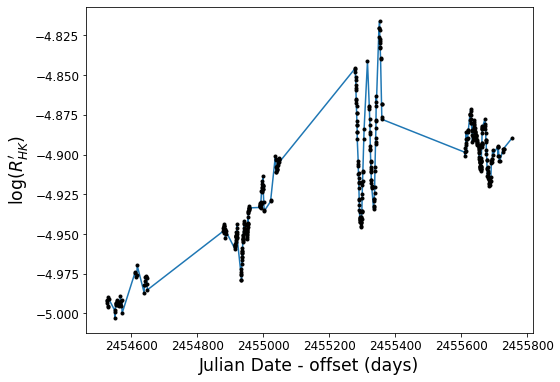

In [3]:
# Read the data
dateD, rvD, rverrD, rHK, rHKerr = \
    np.loadtxt("Dumusque2012_aCenB_Rv.txt", unpack=True, \
    usecols=[0,1,3,7,8], comments="#") # Use "realistic" error bars in col. 3
dateD += 2400000 # Dates in file are JD-2400000
date_offset = 2440000

# Plot log R'HK measurements from Dumusque et al. (2012)
plt.figure(figsize=(8,6))
plt.plot(dateD, rHK)
plt.plot(dateD, rHK, 'k.')
plt.ylabel(r"$\log(R^{\prime}_{HK})$", fontsize="xx-large")
plt.xlabel("Julian Date - offset (days)", fontsize="xx-large")
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)

### Apply Hodrick-Prescott filter to $\log(R^{\prime}_{HK})$, experimenting with different values of $\lambda$

/Users/sdr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/Users/sdr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


     fun: 0.08464623609386956
    nfev: 27
     nit: 19
 success: True
       x: 6.877782324130014


/Users/sdr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/Users/sdr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


     fun: 0.12902555500520746
    nfev: 28
     nit: 18
 success: True
       x: 11.889899715842136


/Users/sdr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/Users/sdr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


     fun: 0.15008120422304524
    nfev: 28
     nit: 17
 success: True
       x: 20.24082246933867


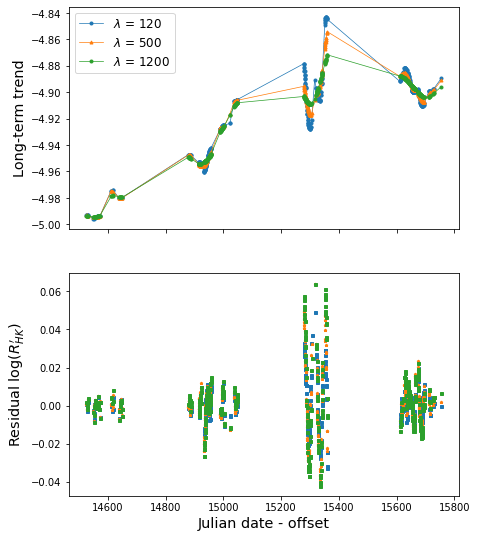

In [4]:
syms = ["o","s","^","*"]
symcycle = cycle(syms)

lams = [120., 500., 1200.]
smooth_RHK = []

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,9))
for l in lams:
    result = minimize_scalar(HPobj, args=(l, dateD, rHK), method="brent")
    rHKsmooth = Gsmooth(dateD, rHK, result.x)
    smooth_RHK.append(rHKsmooth)
    print(result)
    ax1.plot(dateD-date_offset, rHKsmooth, marker=next(symcycle), \
             label=r"$\lambda$ = %d" % l, lw=0.7, markersize=3)
    ax2.plot(dateD-date_offset, rHK-rHKsmooth, marker=next(symcycle), \
             linestyle="none", label=r"$\lambda$ = %d" % l, lw=0.7, \
             markersize=3)
ax2.set_xlabel("Julian date - offset", fontsize="x-large")
ax1.set_ylabel("Long-term trend", fontsize="x-large")
ax2.set_ylabel(r"Residual $\log(R^{\prime}_{HK})$", fontsize="x-large")
ax1.legend(loc="best", fontsize="large")

### Periodogram of the raw $\log(R^{\prime}_{HK})$ dataset

<p>We will restrain <tt>LombScargle</tt> from its default behavior of going way above average Nyquist frequency.</p>

Text(11, 0.4, 'Rotation\nperiod')

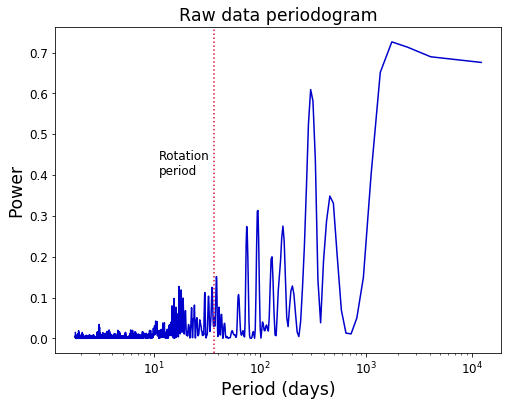

In [5]:
rotper = 36.2 # rotation period in days
xiraw, powraw = LombScargle(dateD, rHK, rHKerr).autopower(nyquist_factor=3)
plt.figure(figsize=(8,6))
plt.semilogx(1./xiraw, powraw, color="mediumblue")
plt.xlabel("Period (days)", fontsize="xx-large")
plt.ylabel("Power", fontsize="xx-large")
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.title("Raw data periodogram", fontsize="xx-large")
plt.axvline(rotper, color="crimson", linestyle=":")
plt.text(11,0.4,"Rotation\nperiod", fontsize="large")

### Periodograms of the $\log(R^{\prime}_{HK})$ long-term trend and residuals:

#### Watch 36.2-day rotation period pop out! You can also see the harmonics at $\lambda = 120$.

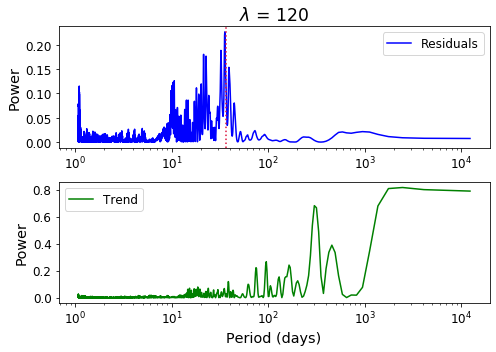

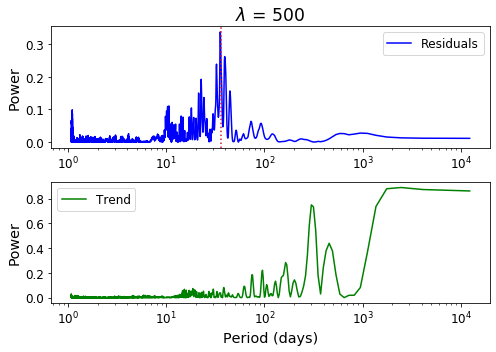

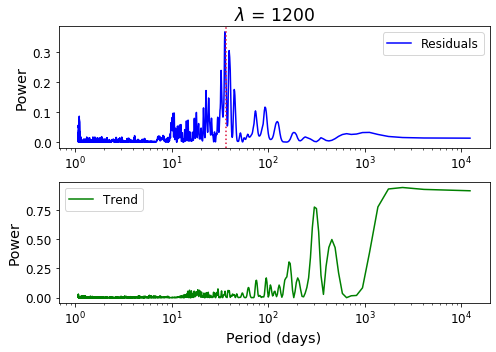

In [6]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(7,5))
    resids = rHK - smooth_RHK[i]
    xiresid, powresid = LombScargle(dateD, resids, rHKerr).autopower()
    xitrend, powtrend = LombScargle(dateD, smooth_RHK[i]).autopower()
    ax1.plot(1./xiresid, powresid, 'b', label="Residuals")
    ax1.axvline(rotper, color="crimson", linestyle=":")
    ax1.set_ylabel("Power", fontsize="x-large")
    ax1.set_xscale("log")
    ax1.legend(loc="best", fontsize="large")
    ax1.set_title(r"$\lambda$ = %d" % lams[i], fontsize="xx-large")
    ax1.tick_params(axis="x", labelsize=12)
    ax1.tick_params(axis="y", labelsize=12)
    ax2.plot(1./xitrend, powtrend, 'g', label="Trend")
    ax2.set_xlabel("Period (days)", fontsize="x-large")
    ax2.set_ylabel("Power", fontsize="x-large")
    ax2.set_xscale("log")
    ax2.legend(loc="best", fontsize="large")
    ax2.tick_params(axis="x", labelsize=12)
    ax2.tick_params(axis="y", labelsize=12)
    fig.tight_layout()